In [1]:
import matplotlib.pyplot as plt
import pandas as pd


from bold_dementia.cogpred import make_training_data, make_all_data
from bold_dementia.utils.configuration import get_config

from neuroginius.atlas import Atlas
from bold_dementia.cogpred import plot_matrix, MatrixResult

config = get_config()
atlas = Atlas.from_name("schaefer200")
matrices, metadata = make_all_data(
    config["connectivity_matrices"],
    atlas.name,
    k=3,
    suffix="corr"
)
aal = atlas.from_name("aal")
aal.networks = list(map(lambda x: str(x).split("_")[0], aal.labels))

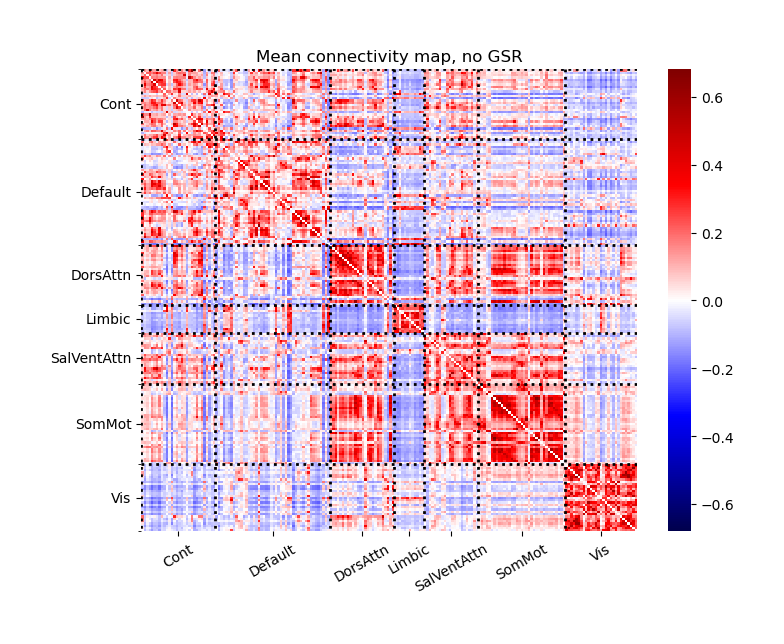

In [2]:
plot_matrix(matrices.mean(axis=0), atlas, cmap="seismic")
plt.title("Mean connectivity map, no GSR")
plt.show()

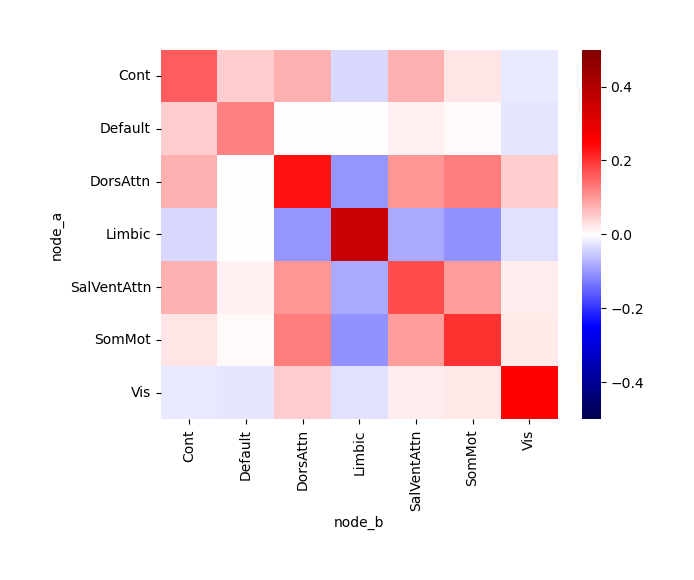

In [42]:
from functools import reduce
import seaborn as sns

mr = MatrixResult(matrices, atlas)
macro_matrix = reduce(lambda x, y: x.add(y) / 2, mr.get_macro_matrices())
sns.heatmap(macro_matrix, cmap="seismic", vmin=-0.5, vmax=0.5)
plt.show()